# Project - Toxic comment classification with NLP and Deep Learning 
                                                                   Deepak Bhadouria, Surendra Pothuri

## Introduction
The main goal of this project is to develop a multi-label classification model capable of accurately identifying different levels of toxicity in online comments. It is based on the "Toxic Comment Classification Challenge," a public Kaggle competition that addresses the task of detecting various types of toxicity in comments. 

## Project Outline

This notebook is organized into the following steps:

* Import Data: Load the dataset
    
* Data Exploration: Analyze and visualize the data to gain insights into the dataset
    
* Data Preparation: Preprocess the text data, including cleaning, tokenization, and TF-IDF
    
* Modeling :
  * Baseline Model : LSTM with single layer
  * Model 1 : Convolutional Neural Network (CNN)
  * Model 2 : Recurrent Neural Network (RNN)
  * Model 4 : Gated Recurrent Unit (GRU)
    
* Evaluation

## Import Libraries

In [95]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import nltk
import pickle
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import string
from wordcloud import WordCloud
from PIL import Image
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer 
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, GRU, SimpleRNN, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping 
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.utils.vis_utils import plot_model
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nehachauhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nehachauhan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nehachauhan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/nehachauhan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [96]:
pd.set_option('display.max_colwidth', 10000)
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print('Trainning set = {} records and Testing set = {} records.'.format(len(train),len(test)))

Trainning set = 159571 records and Testing set = 153164 records.


In [97]:
print("Shape of train data:", train.shape)
print("Shape of test data:", test.shape)

Shape of train data: (159571, 8)
Shape of test data: (153164, 2)


## EDA and Visualization

In [98]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0


In [99]:
test.head()

,id,comment_text
0,00001cee341fdb12,"Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,"
1,0000247867823ef7,"== From RfC == \n\n The title is fine as it is, IMO."
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lapland — / """
3,00017563c3f7919a,":If you have a look back at the source, the information I updated was the correct form. I can only guess the source hadn't updated. I shall update the information once again but thank you for your message."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [100]:
null_train = train.isnull().sum()
null_test = test.isnull().sum()
null_train, null_test

(id               0
 comment_text     0
 toxic            0
 severe_toxic     0
 obscene          0
 threat           0
 insult           0
 identity_hate    0
 dtype: int64,
 id              0
 comment_text    0
 dtype: int64)

* No missing values as of now

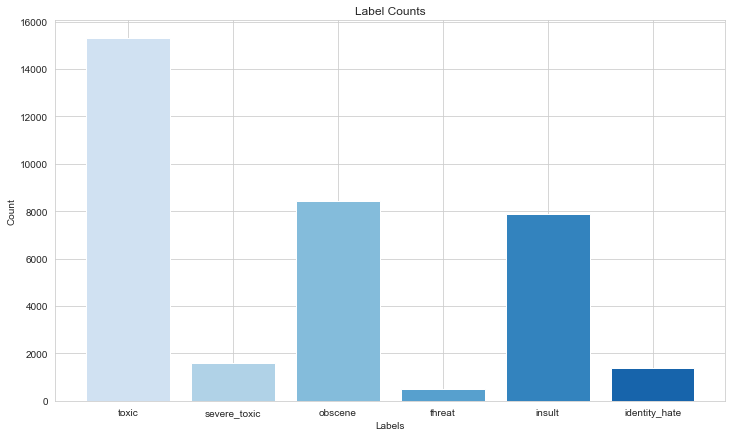

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


In [101]:
labelss = train.iloc[:, 2:].sum()

cmap = plt.get_cmap('Blues')
colors = cmap(np.linspace(0.2, 0.8, len(labelss)))

plt.figure(figsize=(12, 7))
plt.bar(labelss.index, labelss, color=colors)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Counts')
plt.show()

print(labelss)

* There are six labels for a comment as toxic, severe_toxic, threat, obscene, insult, and identity hate. Almost 85% of the toxicity comments comes under toxic, obscene and insult.

* There is multi-tagging, which means some comments can have multiple labels assigned to them. This is fine because a comment that is classified as "severe_toxic" is highly likely to also be classified as "toxic" at the same time.

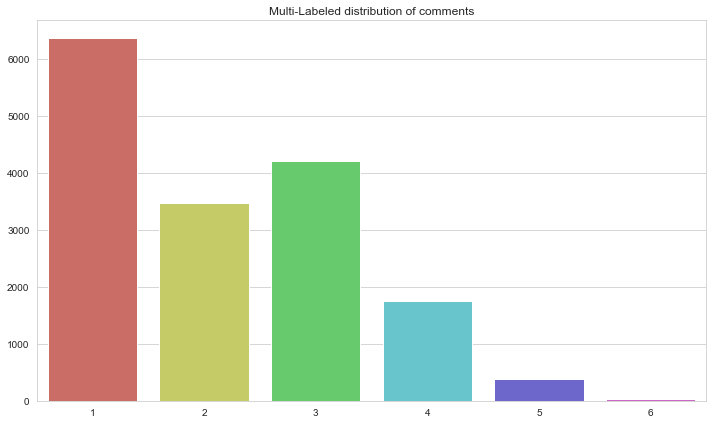

In [102]:
multi_label = train.iloc[:, 2:].sum(axis=1).value_counts()[1:]
fig, ax = plt.subplots(figsize=(12, 7))
sns.barplot(x=multi_label.index,
            y=multi_label.values,
            ax=ax,
            palette="hls").set_title("Multi-Labeled distribution of comments")

plt.show()

In [103]:
labels = train.iloc[:, 2:8]
row_sum = labels.sum(axis=1)

train['Non-toxic'] = (row_sum == 0)

total_comments = len(train)
non_toxic_comments = train['Non-toxic'].sum()
percent_non_toxic = (non_toxic_comments / total_comments) * 100

print('Total comments: {}.'.format(total_comments))
print('Non-toxic comments: {}, which is {:.2f}% of total comments.'.format(non_toxic_comments, percent_non_toxic))

Total comments: 159571.
Non-toxic comments: 143346, which is 89.83% of total comments.


* About 89% of the comments are non-toxic, which means the dataset is highly imbalanced

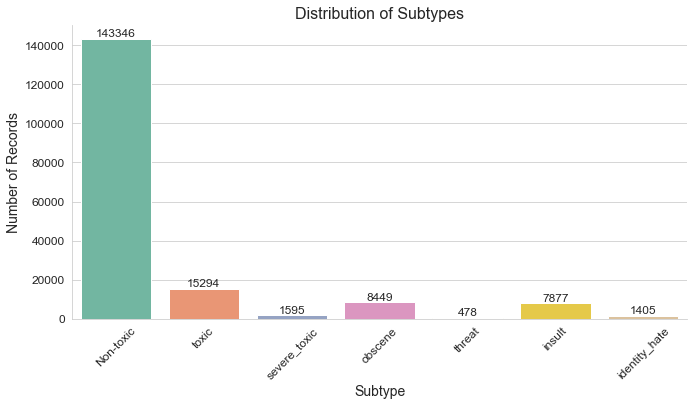

In [104]:
col_sum = pd.Series(labels.sum(axis=0))
Non_toxic = pd.Series(train['Non-toxic'].sum(), index=['Non-toxic'])
col_sum = pd.concat([Non_toxic, col_sum])

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid") 

ax = sns.barplot(col_sum.index, col_sum.values, palette="Set2")

for rect, label in zip(ax.patches, col_sum.values):
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), label,
            ha='center', va='bottom', fontsize=12)

plt.xlabel('Subtype', fontsize=14)
plt.ylabel('Number of Records', fontsize=14)
plt.title('Distribution of Subtypes', fontsize=16)

plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

sns.despine()
plt.tight_layout(pad=2)
plt.show()

In [105]:
diff_comm = ['Non-toxic', 'toxic','severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for t in diff_comm:
    record_number = random.randint(1, train[t].sum())
    print('{}th record is "{}":'.format(record_number,t))
    print(train[train[t] == 1].iloc[record_number,1])
    print('')

43628th record is "Non-toxic":
Please stop vandalising articles or you will be blocked from editing.   16:47, 29 Mar 2004 (UTC)

11600th record is "toxic":
"Wow! This is unbelievably sexist and demeaning. You punish me for complaining about being called a ""cunt"" and having having the words ""cock shit"" and ""fucking"" used against me repeatedly. That essentially condones that type of conduct.

"

1177th record is "severe_toxic":
Now Gaba p joins the long list of complete fucking assholes who revert every minor edit of the Younger Dryas impact hypothesis wiki page. Let me give you a clue, fuckface, you can't possibly justify reverting an edit that simply ads another tertiary peer reviewed publication related to this subject. It's inane, it's anal, it's uniformed and it's just plain wrong.

1332th record is "obscene":
Randi was born a DICK.  Randi will never overcome being a DICK.  The end.

166th record is "threat":
I'LL KILL YOU ALL!!!!

3773th record is "insult":
Dear Wikipedia ass

* An example of all types of comments in the dataset to show the difference

In [106]:
train['comment_text'][0:10]

0                                                                                                                                                                                                                                                                                                                                                                             Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
1                                                                                                                                                                                                                                                                                                                                                                               

## Data pre-processing

In [107]:
#splitting by white space, removal of puntuation from strngs, non-alpha char, stopwords, convert to lowercase, lemmatize  

def cleaner(text_record):
    tokens = text_record.split()
    table = str.maketrans({key: None for key in string.punctuation})
    tokens = [token.translate(table) for token in tokens]
    tokens = [token for token in tokens if token.isalpha()]
    tokens = [token.lower() for token in tokens]
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    lem = WordNetLemmatizer()
    tokens = [lem.lemmatize(token, "v") for token in tokens]
    sentence = ' '.join(tokens)
    return sentence

*Splitting by White Space: Comments are divided into individual words or tokens based on white spaces.

*Removal of Punctuation: Punctuation marks are removed from the strings to focus on the words themselves.

*Handling Non-Alphabetic Characters: Non-alphabetic characters like numbers or special symbols are either *removed or included in the tokenization process.

*Stopword Removal: Common words that lack significant meaning, such as "and," "the," or "is," are filtered out.

*Conversion to Lowercase: All words are converted to lowercase to ensure consistency.

*Lemmatization: Words are transformed into their baseform to reduce inflectional variations.

In [108]:
train_cleaned = [cleaner(comment) for comment in train.comment_text.copy()]
test_cleaned = [cleaner(comment) for comment in test.comment_text.copy()]

In [109]:
train_cleaned[0:10]

['explanation edit make username hardcore metallica fan revert werent vandalisms closure gas vote new york dolls fac please dont remove template talk page since im retire',
 'daww match background colour im seemingly stick thank talk january utc',
 'hey man im really try edit war guy constantly remove relevant information talk edit instead talk page seem care format actual info',
 'cant make real suggestions improvement wonder section statistics later subsection type accidents think reference may need tidy exact format ie date format etc later noone else first preferences format style reference want please let know appear backlog article review guess may delay reviewer turn list relevant form eg wikipediagoodarticlenominationstransport',
 'sir hero chance remember page thats',
 'congratulations well use tool well talk',
 'cocksucker piss around work',
 'vandalism matt shirvington article revert please dont ban',
 'sorry word nonsense offensive anyway im intend write anything articlewow

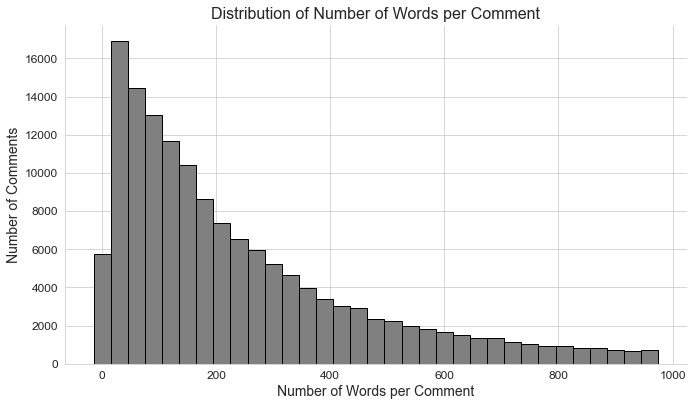

No. with maximum count: 30
Count: 16908


In [110]:
num_words = [len(comment) for comment in train.comment_text]

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
hist, bins = np.histogram(num_words, bins=np.arange(0, 1000, 30))

bar_color = 'gray'
plt.bar(bins[:-1], hist, width=30, color=bar_color, edgecolor='black')

plt.xlabel('Number of Words per Comment', fontsize=14)
plt.ylabel('Number of Comments', fontsize=14)
plt.title('Distribution of Number of Words per Comment', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

sns.despine()
plt.tight_layout(pad=2)
plt.show()

max_count = np.max(hist)
max_num_words = bins[np.argmax(hist)]

print("No. with maximum count:", max_num_words)
print("Count:", max_count)

## Tokenization and Padding

In [111]:
max_features = 25000
tokens = Tokenizer(num_words = max_features)
tokens.fit_on_texts(train_cleaned)
train_encoded = tokens.texts_to_sequences(train_cleaned)
test_encoded = tokens.texts_to_sequences(test_cleaned)

print('Vocab_size = {}.'.format(len(tokens.word_index)))

Vocab_size = 204344.


In [112]:
max_len = 250
X_train = pad_sequences(train_encoded, maxlen = max_len, padding = 'post')
X_test = pad_sequences(test_encoded, maxlen = max_len, padding = 'post')

attribute_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y_train = train[attribute_names].values

In [113]:
print('X_train shape is {}'.format(X_train.shape))
print('y_train shape is {}'.format(y_train.shape))

X_train shape is (159571, 250)
y_train shape is (159571, 6)


# Model Implementation

## Logistic Regression with Cross_val scores

In [114]:
'''Imbalanced-learn currently supports binary, multiclass and binarized encoded multiclasss targets. 
Multilabel and multioutput targets are not supported.''' 
word_vectors = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 6),
    max_features=25000
)

word_vectors.fit(train_cleaned)
train_features = word_vectors.transform(train_cleaned)
test_features = word_vectors.transform(test_cleaned)

In [115]:
cross_scores = []
for attri_name in attribute_names:
    train_target = train[attri_name]
    classifier = LogisticRegression(C=0.2, solver='sag')
    cv_scores = cross_val_score(classifier, train_features, train_target, cv=3, scoring='roc_auc')
    cv_score = np.mean(cv_scores)
    cross_scores.append(cv_score)
    print('Cross_Val score for "{}" is {}'.format(attri_name, cv_score))
    classifier.fit(train_features, train_target)
    
print('Total Cross_Val score is {}'.format(np.mean(cross_scores)))

Cross_Val score for "toxic" is 0.9621010138496343
Cross_Val score for "severe_toxic" is 0.9824662599178403
Cross_Val score for "obscene" is 0.9808299436287323
Cross_Val score for "threat" is 0.9760240792518138
Cross_Val score for "insult" is 0.9712170245789989
Cross_Val score for "identity_hate" is 0.9688836814091671
Total Cross_Val score is 0.9735870004393644


* Functions to: 

calculate the AUC-ROC metric.

compile, train, and evaluate the model.

In [116]:
class roc_auc(Callback):
    def __init__(self, training_data, validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
 
    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)
        
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc, 4)), str(round(roc_val, 4))), end=100 * ' ' + '\n')

In [117]:
def train_model(model, X_train, y_train, X_val, y_val, batch_size, epochs, filepath):
    # callbacks
    checkpointer = ModelCheckpoint(filepath=filepath, verbose=1, save_best_only=True)
    
    roc = roc_auc(training_data=(X_train, y_train), validation_data=(X_val, y_val))
    
    # fit the model
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks=[roc, checkpointer])
    
    # load the model with the best validation loss
    model.load_weights(filepath)
    
    return model, history

## Baseline Model: LSTM

In [118]:
lstm = Sequential()
lstm.add(Embedding(max_features, 100, input_length=max_len))
lstm.add(LSTM(64))
lstm.add(Dropout(0.25))
lstm.add(Dense(6, activation="sigmoid"))

lstm.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

lstm.summary()

2023-06-14 22:35:06.577742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-14 22:35:06.599083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-14 22:35:06.610039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 250, 100)          2500000   
                                                                 
 lstm_1 (LSTM)               (None, 64)                42240     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 6)                 390       
                                                                 
Total params: 2,542,630
Trainable params: 2,542,630
Non-trainable params: 0
_________________________________________________________________


In [119]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.9, random_state=30)

lstm_trained, history_lstm = train_model(lstm,
                                         X_train, y_train,
                                         X_val, y_val,
                                         batch_size=512,
                                         epochs=3,
                                         filepath='saved_models/weights.best.from_scatch_lstm.hdf5')

Epoch 1/3


2023-06-14 22:35:08.366709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-14 22:35:08.373846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-14 22:35:08.378438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

281/281 [==============================] - ETA: 0s - loss: 0.4015 - accuracy: 0.2563

2023-06-14 22:42:23.388009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-14 22:42:23.391402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-14 22:42:23.394991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

499/499 [==============================] - 16s 32ms/step
roc-auc: 0.502 - roc-auc_val: 0.5123                                                                                                    

Epoch 1: val_loss improved from inf to 0.36188, saving model to saved_models/weights.best.from_scatch_lstm.hdf5
281/281 [==============================] - 652s 2s/step - loss: 0.4015 - accuracy: 0.2563 - val_loss: 0.3619 - val_accuracy: 0.0018
Epoch 2/3
499/499 [==============================] - 18s 36ms/step
roc-auc: 0.5045 - roc-auc_val: 0.5144                                                                                                    

Epoch 2: val_loss improved from 0.36188 to 0.35654, saving model to saved_models/weights.best.from_scatch_lstm.hdf5
281/281 [==============================] - 589s 2s/step - loss: 0.3978 - accuracy: 0.2863 - val_loss: 0.3565 - val_accuracy: 0.0018
Epoch 3/3
499/499 [==============================] - 28s 56ms/step
roc-auc: 0.5043 - roc-auc_val: 0.5141   

In [120]:
# save the model
with open('lstm_model.pkl', 'wb') as f:
    pickle.dump(lstm, f)
    
with open('lstm_model.pkl', 'rb') as f:
    lstm_model = pickle.load(f)    

2023-06-14 23:07:44.628496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-14 23:07:44.629867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-14 23:07:44.631537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [121]:
y_pred_val = lstm_model.predict(X_val)

auc = roc_auc_score(y_val, y_pred_val)
print("LSTM_AUC: %.2f%%" % (auc * 100))

2023-06-14 23:07:52.753718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-14 23:07:52.760223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-14 23:07:52.764844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

499/499 [==============================] - 21s 41ms/step
LSTM_AUC: 51.41%


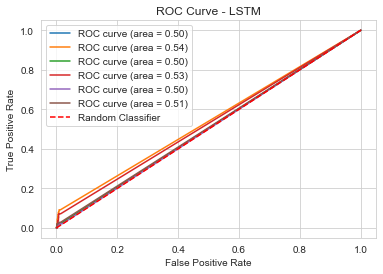

toxic AUC: 50.34%
severe_toxic AUC: 53.95%
obscene AUC: 50.42%
threat AUC: 52.90%
insult AUC: 50.09%
identity_hate AUC: 50.74%


In [122]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(attribute_names)):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_pred_val[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(len(attribute_names)):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])

plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LSTM')
plt.legend()
plt.show()

for i in range(len(attribute_names)):
    print(attribute_names[i] + ' AUC: %.2f%%' % (roc_auc[i] * 100))

## Model 1: SimpleRNN with an Embedding layer and the RNN layer.

In [125]:
class roc_auc(Callback):
    def __init__(self, training_data, validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
 
    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)
        
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc, 4)), str(round(roc_val, 4))), end=100 * ' ' + '\n')

In [126]:
def train_model(model, X_train, y_train, X_val, y_val, batch_size, epochs, filepath):
    # callbacks
    checkpointer = ModelCheckpoint(filepath=filepath, verbose=1, save_best_only=True)
    
    roc = roc_auc(training_data=(X_train, y_train), validation_data=(X_val, y_val))
    
    # fit the model
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks=[roc, checkpointer])
    
    # load the model with the best validation loss
    model.load_weights(filepath)
    
    return model, history

In [127]:
rnn = Sequential()
rnn.add(Embedding(max_features, 100, input_length=max_len))
rnn.add(SimpleRNN(100))
rnn.add(Dense(6, activation='sigmoid'))
rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
rnn.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 250, 100)          2500000   
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 100)               20100     
                                                                 
 dense_10 (Dense)            (None, 6)                 606       
                                                                 
Total params: 2,520,706
Trainable params: 2,520,706
Non-trainable params: 0
_________________________________________________________________


In [128]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.9, random_state=30)
rnn_trained, history_rnn = train_model(rnn,
                                X_train,y_train,
                                X_val,y_val,
                                batch_size=512, 
                                epochs=5,
                                filepath='saved_models/weights.best.from_scratch_rnn.hdf5')

Epoch 1/5
404/404 [==============================] - 11s 27ms/step
roc-auc: 0.5048 - roc-auc_val: 0.5053                                                                                                    

Epoch 1: val_loss improved from inf to 0.14226, saving model to saved_models/weights.best.from_scratch_rnn.hdf5
228/228 [==============================] - 318s 1s/step - loss: 0.1564 - accuracy: 0.9043 - val_loss: 0.1423 - val_accuracy: 0.9937
Epoch 2/5
404/404 [==============================] - 10s 23ms/step
roc-auc: 0.5315 - roc-auc_val: 0.5225                                                                                                    

Epoch 2: val_loss did not improve from 0.14226
228/228 [==============================] - 306s 1s/step - loss: 0.1411 - accuracy: 0.9930 - val_loss: 0.1433 - val_accuracy: 0.9915
Epoch 3/5
404/404 [==============================] - 14s 35ms/step
roc-auc: 0.5048 - roc-auc_val: 0.5065                                                             

* Saving the model using pickle

In [129]:
# Save the model

with open('rnn_model.pkl', 'wb') as f:
    pickle.dump(rnn, f)
    
with open('rnn_model.pkl', 'rb') as f:
    rnn_model = pickle.load(f)    

In [130]:
y_pred_val = rnn_model.predict(X_val)

auc = roc_auc_score(y_val, y_pred_val)
print("RNN_AUC: %.2f%%" % (auc * 100))

404/404 [==============================] - 9s 22ms/step
RNN_AUC: 50.53%


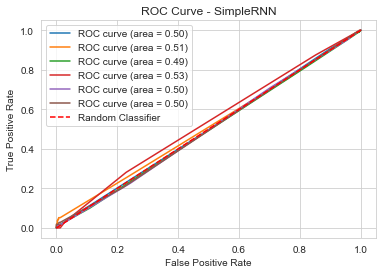

toxic AUC: 50.16%
severe_toxic AUC: 51.28%
obscene AUC: 49.39%
threat AUC: 53.07%
insult AUC: 49.64%
identity_hate AUC: 49.64%


In [131]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(attribute_names)):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_pred_val[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(len(attribute_names)):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])

plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SimpleRNN')
plt.legend()
plt.show()

for i in range(len(attribute_names)):
    print(attribute_names[i] + ' AUC: %.2f%%' % (roc_auc[i] * 100))

## Model 2 : CNN - with 2 convolutional layers, 2 dense layers, and 3 dropout layers

In [ ]:
class roc_auc(Callback):
    def __init__(self, training_data, validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
 
    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)
        
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc, 4)), str(round(roc_val, 4))), end=100 * ' ' + '\n')

In [ ]:
def train_model(model, X_train, y_train, X_val, y_val, batch_size, epochs, filepath):
    # callbacks
    checkpointer = ModelCheckpoint(filepath=filepath, verbose=1, save_best_only=True)
    
    roc = roc_auc(training_data=(X_train, y_train), validation_data=(X_val, y_val))
    
    # fit the model
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks=[roc, checkpointer])
    
    # load the model with the best validation loss
    model.load_weights(filepath)
    
    return model, history

In [57]:
cnn = Sequential()
cnn.add(Embedding(max_features, 200, input_length=max_len))  
cnn.add(Conv1D(filters=32, kernel_size=3, activation='relu'))  
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Dropout(0.5))
cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu'))  
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Dropout(0.5))
cnn.add(Flatten())
cnn.add(Dense(500, activation="relu")) 
cnn.add(Dropout(0.5))
cnn.add(Dense(6, activation="sigmoid"))
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 250, 200)          5000000   
                                                                 
 conv1d_2 (Conv1D)           (None, 248, 32)           19232     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 124, 32)          0         
 1D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 124, 32)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 122, 64)           6208      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 61, 64)           0         
 1D)                                                  

In [58]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.9, random_state=30)

cnn_trained, history_cnn = train_model(cnn,
                                       X_train,y_train,
                                       X_val,y_val,
                                       batch_size=512, 
                                       epochs=3,
                                       filepath='saved_models/weights.best.from_scatch_cnn.hdf5')

Epoch 1/3
499/499 [==============================] - 10s 20ms/step
roc-auc: 0.9624 - roc-auc_val: 0.9533                                                                                                    

Epoch 1: val_loss improved from inf to 0.06937, saving model to saved_models/weights.best.from_scatch_cnn.hdf5
281/281 [==============================] - 352s 1s/step - loss: 0.1100 - accuracy: 0.8158 - val_loss: 0.0694 - val_accuracy: 0.9946
Epoch 2/3
499/499 [==============================] - 10s 21ms/step
roc-auc: 0.9792 - roc-auc_val: 0.9683                                                                                                    

Epoch 2: val_loss improved from 0.06937 to 0.06175, saving model to saved_models/weights.best.from_scatch_cnn.hdf5
281/281 [==============================] - 316s 1s/step - loss: 0.0584 - accuracy: 0.9751 - val_loss: 0.0618 - val_accuracy: 0.9946
Epoch 3/3
499/499 [==============================] - 9s 19ms/step
roc-auc: 0.9824 - roc-auc_val: 0

In [88]:
with open('cnn_model.pkl', 'wb') as f:
    pickle.dump(cnn, f)

In [89]:
with open('cnn_model.pkl', 'rb') as f:
    cnn_model = pickle.load(f)

In [90]:
y_pred_val = cnn_model.predict(X_val)

auc = roc_auc_score(y_val, y_pred_val)
print("CNN_AUC: %.2f%%" % (auc * 100))

404/404 [==============================] - 8s 20ms/step
CNN_AUC: 98.12%


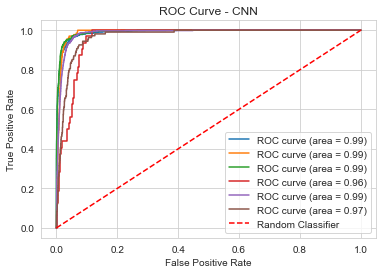

toxic AUC: 99.01%
severe_toxic AUC: 98.93%
obscene AUC: 99.21%
threat AUC: 96.02%
insult AUC: 98.61%
identity_hate AUC: 96.92%


In [91]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
auc_score = dict()

for i in range(len(attribute_names)):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_pred_val[:, i])
    auc_score[i] = auc(fpr[i], tpr[i])

for i in range(len(attribute_names)):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % auc_score[i])

plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CNN')
plt.legend()
plt.show()

for i in range(len(attribute_names)):
    print(attribute_names[i] + ' AUC: %.2f%%' % (auc_score[i] * 100))

## Model 3 : GRU with an Embedding layer and the GRU layer

In [ ]:
class roc_auc(Callback):
    def __init__(self, training_data, validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
 
    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)
        
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc, 4)), str(round(roc_val, 4))), end=100 * ' ' + '\n')

In [ ]:
def train_model(model, X_train, y_train, X_val, y_val, batch_size, epochs, filepath):
    # callbacks
    checkpointer = ModelCheckpoint(filepath=filepath, verbose=1, save_best_only=True)
    
    roc = roc_auc(training_data=(X_train, y_train), validation_data=(X_val, y_val))
    
    # fit the model
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks=[roc, checkpointer])
    
    # load the model with the best validation loss
    model.load_weights(filepath)
    
    return model, history

In [69]:
gru = Sequential()
gru.add(Embedding(max_features, 200, input_length=max_len))
gru.add(GRU(32, dropout=0.2, recurrent_dropout=0.2))  # Add GRU layer with 32 units
gru.add(Dense(6, activation='sigmoid'))

gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
gru.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 250, 200)          5000000   
                                                                 
 gru_1 (GRU)                 (None, 32)                22464     
                                                                 
 dense_7 (Dense)             (None, 6)                 198       
                                                                 
Total params: 5,022,662
Trainable params: 5,022,662
Non-trainable params: 0
_________________________________________________________________


In [70]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.9, random_state=30)

gru_trained, history_gru = train_model(gru,
                                       X_train, y_train,
                                       X_val, y_val,
                                       batch_size=512,
                                       epochs=3,
                                       filepath='saved_models/weights.best.from_scatch_gru.hdf5')

Epoch 1/3
404/404 [==============================] - 17s 42ms/step
roc-auc: 0.4959 - roc-auc_val: 0.5045                                                                                                    

Epoch 1: val_loss improved from inf to 0.14205, saving model to saved_models/weights.best.from_scatch_gru.hdf5
228/228 [==============================] - 686s 3s/step - loss: 0.1822 - accuracy: 0.7917 - val_loss: 0.1421 - val_accuracy: 0.9932
Epoch 2/3
404/404 [==============================] - 19s 48ms/step
roc-auc: 0.5021 - roc-auc_val: 0.5012                                                                                                    

Epoch 2: val_loss did not improve from 0.14205
228/228 [==============================] - 640s 3s/step - loss: 0.1402 - accuracy: 0.9936 - val_loss: 0.1421 - val_accuracy: 0.9933
Epoch 3/3
404/404 [==============================] - 21s 51ms/step
roc-auc: 0.5811 - roc-auc_val: 0.578                                                               

In [92]:
with open('gru_model.pkl', 'wb') as f:
    pickle.dump(gru, f)

In [93]:
with open('gru_model.pkl', 'rb') as f:
    gru_model = pickle.load(f)

In [73]:
y_pred_val = gru_model.predict(X_val)

auc = roc_auc_score(y_val, y_pred_val)
print("GRU_AUC: %.2f%%" % (auc * 100))

404/404 [==============================] - 17s 41ms/step
GRU_AUC: 57.80%


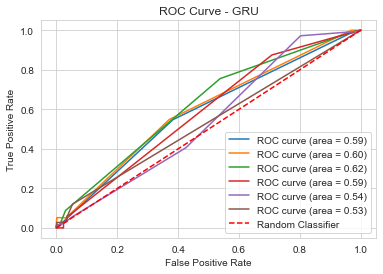

toxic AUC: 58.53%
severe_toxic AUC: 59.76%
obscene AUC: 62.26%
threat AUC: 58.73%
insult AUC: 54.19%
identity_hate AUC: 53.34%


In [77]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(attribute_names)):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_pred_val[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(len(attribute_names)):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])

plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - GRU')
plt.legend()
plt.show()

for i in range(len(attribute_names)):
    print(attribute_names[i] + ' AUC: %.2f%%' % (roc_auc[i] * 100))

## Result and Conclusion
Various deep learning models were explored which includes GRU, LSTM, Simple RNN, CNN. The CNN model achieved the highest ROC AUC score of approximately 96% (SIGNS OF OVERFITTING), outperforming the other models. Also, n-grams TF-IDF Vectorizer is applied for the Logistic Regression model, It showed strong performance with a cross-validation score of 97%. 

F1 could also be used as an evaluation metric, it provides an overall performance measure that takes into account both the ability of the model to correctly identify positive instances (recall) and the ability to avoid misclassifying negative instances (precision).